In [22]:
# ==============================
# Imports & Setup
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
import sqlite3
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

plt.style.use("default")

print("✅ Environment setup complete")

✅ Environment setup complete


In [ ]:
# ==============================
# Data Loading
# ==============================

df = pd.read_csv("/content/Messy_HR_Dataset_Detailed.csv")

print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())

df.head()

Dataset Shape: (3150, 39)

Column Names:
 ['Unnamed: 0', 'FirstName', 'LastName', 'StartDate', 'ExitDate', 'Title', 'Supervisor', 'ADEmail', 'BusinessUnit', 'EmployeeStatus', 'EmployeeType', 'PayZone', 'EmployeeClassificationType', 'TerminationType', 'TerminationDescription', 'DepartmentType', 'Division', 'DOB', 'State', 'JobFunctionDescription', 'GenderCode', 'LocationCode', 'RaceDesc', 'MaritalDesc', 'Performance Score', 'Current Employee Rating', 'Employee ID', 'Survey Date', 'Engagement Score', 'Satisfaction Score', 'Work-Life Balance Score', 'Training Date', 'Training Program Name', 'Training Type', 'Training Outcome', 'Location', 'Trainer', 'Training Duration(Days)', 'Training Cost']


,Unnamed: 0,FirstName,LastName,StartDate,ExitDate,Title,Supervisor,ADEmail,BusinessUnit,EmployeeStatus,...,Satisfaction Score,Work-Life Balance Score,Training Date,Training Program Name,Training Type,Training Outcome,Location,Trainer,Training Duration(Days),Training Cost
0,0,Uriah,Bridges,20-Sep-19,NaN,Production Technician I,Peter Oneill,uriah.bridges@bilearner.com,CCDR,Active,...,2,3,15-Jul-23,Leadership Development,Internal,Failed,South Marisa,Taylor Rodriguez,2,606.11
1,1,Paula,Small,11-Feb-23,NaN,Production Technician I,Renee Mccormick,paula.small@bilearner.com,EW,Active,...,1,5,12-Sep-22,Customer Service,External,Incomplete,Tammieville,Kelly Patterson DDS,4,673.02
2,2,Edward,Buck,10-Dec-18,NaN,Area Sales Manager,Crystal Walker,edward.buck@bilearner.com,PL,Active,...,2,1,13-Aug-22,Leadership Development,External,Failed,East Roberthaven,Taylor Thomas,2,413.28
3,3,Michael,Riordan,21-Jun-21,NaN,Area Sales Manager,Rebekah Wright,michael.riordan@bilearner.com,CCDR,Active,...,5,4,15-Dec-22,Project Management,External,Completed,Garzatown,Holly Elliott,3,663.78
4,4,Jasmine,Onque,29-Jun-19,NaN,Area Sales Manager,Jason Kim,jasmine.onque@bilearner.com,TNS,Active,...,5,3,13-Jul-23,Technical Skills,External,Failed,Lake Meganville,Donald Martinez,5,399.03


In [ ]:
# ==============================
# Remove Junk Columns
# ==============================

if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

print("Remaining columns:", df.shape[1])

Remaining columns: 38


In [ ]:
# ==============================
# Missing Value Report
# ==============================

missing_report = (
    df.isnull()
      .mean()
      .mul(100)
      .sort_values(ascending=False)
      .to_frame("missing_percentage")
)

missing_report.head(10)

,missing_percentage
ExitDate,49.015873
TerminationDescription,49.015873
LastName,0.000000
StartDate,0.000000
Title,0.000000
FirstName,0.000000
Supervisor,0.000000
ADEmail,0.000000
EmployeeStatus,0.000000
BusinessUnit,0.000000


In [ ]:
# ==============================
# Duplicate Employee Check
# ==============================

df["Employee ID"].duplicated().sum()

np.int64(150)

In [ ]:
# ==============================
# Date Parsing
# ==============================

date_cols = [
    "StartDate", "ExitDate", "DOB",
    "Survey Date", "Training Date"
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

df[date_cols].dtypes

,0
StartDate,datetime64[ns]
ExitDate,datetime64[ns]
DOB,datetime64[ns]
Survey Date,datetime64[ns]
Training Date,datetime64[ns]


In [ ]:
# ==============================
# Logical Date Checks
# ==============================

invalid_dates = df[
    (df["ExitDate"].notna()) &
    (df["ExitDate"] < df["StartDate"])
]

print("Invalid ExitDate rows:", invalid_dates.shape[0])

Invalid ExitDate rows: 0


In [ ]:
# ==============================
# Resolve Duplicate Employees
# ==============================

df = df.sort_values(by=["Employee ID", "Survey Date"])
df = df.drop_duplicates(subset="Employee ID", keep="last")

print("Shape after deduplication:", df.shape)

Shape after deduplication: (3000, 38)


In [ ]:
# ==============================
# Handle TerminationDescription
# ==============================

df["TerminationDescription"] = np.where(
    df["ExitDate"].notna(),
    df["TerminationDescription"],
    "Not Applicable"
)

df["TerminationDescription"].value_counts().head()

,count
TerminationDescription,
Not Applicable,1467
Stay word behavior financial.,1
Enough final gun case.,1
Left she before though finally.,1
Fire necessary sing first traditional.,1


In [ ]:
# ==============================
# Attrition Flag
# ==============================

df["attrition_flag"] = np.where(df["ExitDate"].notna(), 1, 0)

df["attrition_flag"].value_counts()

,count
attrition_flag,
1,1533
0,1467


In [ ]:
# ==============================
# Tenure Calculation
# ==============================

reference_date = pd.to_datetime("today")

df["tenure_years"] = np.where(
    df["attrition_flag"] == 1,
    (df["ExitDate"] - df["StartDate"]).dt.days / 365,
    (reference_date - df["StartDate"]).dt.days / 365
)

df["tenure_years"].describe()

,tenure_years
count,3000.000000
mean,3.073829
std,2.193573
min,0.000000
25%,1.049315
50%,2.900000
75%,4.827397
max,7.416438


In [ ]:
# ==============================
# Age Calculation
# ==============================

df["age"] = (reference_date - df["DOB"]).dt.days / 365

df["age"].describe()

,age
count,1177.000000
mean,54.347733
std,17.511220
min,24.183562
25%,38.539726
50%,53.931507
75%,69.208219
max,84.956164


In [ ]:
# ==============================
# Tenure Buckets
# ==============================

df["tenure_bucket"] = pd.cut(
    df["tenure_years"],
    bins=[0, 1, 3, 6, 50],
    labels=["<1 yr", "1–3 yrs", "3–6 yrs", "6+ yrs"]
)

df["tenure_bucket"].value_counts()

,count
tenure_bucket,
3–6 yrs,1046
1–3 yrs,820
<1 yr,719
6+ yrs,409


In [ ]:
# ==============================
# Engagement Score
# ==============================

df["engagement_proxy"] = (
    df["Engagement Score"] * 0.4 +
    df["Satisfaction Score"] * 0.3 +
    df["Work-Life Balance Score"] * 0.3
)

df["engagement_proxy"].describe()

,engagement_proxy
count,3000.000000
mean,2.979167
std,0.826093
min,1.000000
25%,2.400000
50%,3.000000
75%,3.600000
max,5.000000


In [ ]:
# ==============================
# Age Missing Handling
# ==============================

# 1. Create missing flag
df["age_missing_flag"] = np.where(df["age"].isna(), 1, 0)

# 2. Impute missing age using median
age_median = df["age"].median()
df["age"] = df["age"].fillna(age_median)

# 3. Validation
print("Missing ages after imputation:", df["age"].isna().sum())
print("\nAge missing flag counts:")
print(df["age_missing_flag"].value_counts())

df["age"].describe()

Missing ages after imputation: 0

Age missing flag counts:
age_missing_flag
1    1823
0    1177
Name: count, dtype: int64


,age
count,3000.000000
mean,54.094806
std,10.967469
min,24.183562
25%,53.931507
50%,53.931507
75%,53.931507
max,84.956164


In [23]:
# ==============================
# Outlier Handling
# ==============================

numeric_cols = [
    "age",
    "tenure_years",
    "Training Cost",
    "Training Duration(Days)",
    "engagement_proxy"
]

for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

# Validation summary
df[numeric_cols].describe()

,age,tenure_years,Training Cost,Training Duration(Days),engagement_proxy
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,54.096932,3.073468,558.629990,2.975667,2.979667
std,10.924056,2.192466,263.097663,1.417890,0.817775
min,26.166411,0.021918,107.137700,1.000000,1.300000
25%,53.931507,1.049315,327.587500,2.000000,2.400000
50%,53.931507,2.900000,572.125000,3.000000,3.000000
75%,53.931507,4.827397,786.987500,4.000000,3.600000
max,83.145890,7.315068,993.760300,5.000000,4.700000


In [24]:
# ==============================
# Tenure Bucket Correction
# ==============================

df["tenure_bucket"] = pd.cut(
    df["tenure_years"],
    bins=[-0.01, 1, 3, 6, 100],
    labels=["<1 yr", "1–3 yrs", "3–6 yrs", "6+ yrs"],
    include_lowest=True
)

df["tenure_bucket"].isna().sum(), df["tenure_bucket"].value_counts()

(np.int64(0),
 tenure_bucket
 3–6 yrs    1046
 1–3 yrs     820
 <1 yr       725
 6+ yrs      409
 Name: count, dtype: int64)

In [25]:
# ==============================
# Create SQL Database
# ==============================

import sqlite3

conn = sqlite3.connect("hr_analytics.db")

df.to_sql(
    name="hr_data",
    con=conn,
    if_exists="replace",
    index=False
)

print("✅ Data successfully written to SQL table: hr_data")

✅ Data successfully written to SQL table: hr_data


In [26]:
# ==============================
#  Correct Attrition Driver Analysis
# ==============================

query_attrition_engagement = """
SELECT
    CASE
        WHEN engagement_proxy < 2 THEN 'Low Engagement'
        WHEN engagement_proxy BETWEEN 2 AND 3.5 THEN 'Medium Engagement'
        ELSE 'High Engagement'
    END AS engagement_level,
    COUNT(*) AS total_employees,
    SUM(attrition_flag) AS exited_employees,
    ROUND(100.0 * SUM(attrition_flag) / COUNT(*), 2) AS attrition_rate_pct
FROM hr_data
GROUP BY engagement_level
ORDER BY attrition_rate_pct DESC;
"""

pd.read_sql_query(query_attrition_engagement, conn)

,engagement_level,total_employees,exited_employees,attrition_rate_pct
0,Low Engagement,366,195,53.28
1,High Engagement,754,385,51.06
2,Medium Engagement,1880,953,50.69


In [27]:
# ==============================
# Training ROI
# ==============================

query_2 = """
SELECT
    "Training Type" AS training_type,
    COUNT(*) AS employees,
    ROUND(AVG("Training Cost"), 2) AS avg_cost,
    ROUND(AVG("Current Employee Rating"), 2) AS avg_rating
FROM hr_data
GROUP BY "Training Type"
ORDER BY avg_rating DESC;
"""

pd.read_sql_query(query_2, conn)

,training_type,employees,avg_cost,avg_rating
0,Internal,1509,560.42,2.99
1,External,1491,556.82,2.95


In [28]:
# ==============================
# High Performer Attrition
# ==============================

query_3 = """
SELECT
    DepartmentType,
    COUNT(*) AS high_performers,
    SUM(attrition_flag) AS exited_high_performers
FROM hr_data
WHERE "Current Employee Rating" >= 4
GROUP BY DepartmentType
ORDER BY exited_high_performers DESC;
"""

pd.read_sql_query(query_3, conn)

,DepartmentType,high_performers,exited_high_performers
0,Production,471,251
1,Sales,128,59
2,IT/IS,75,38
3,Software Engineering,11,8
4,Admin Offices,4,1


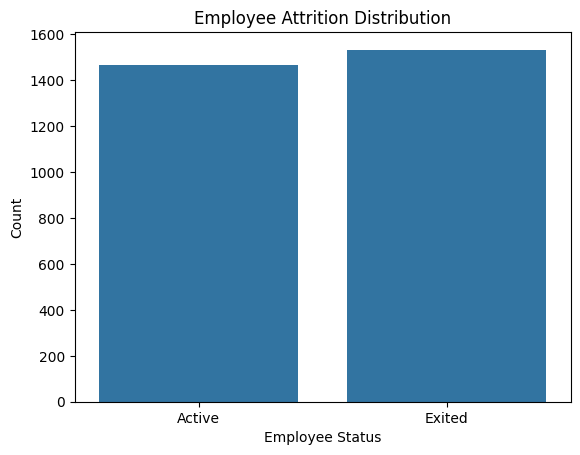

In [29]:
# ==============================
# Overall Attrition
# ==============================

sns.countplot(x="attrition_flag", data=df)
plt.title("Employee Attrition Distribution")
plt.xticks([0, 1], ["Active", "Exited"])
plt.xlabel("Employee Status")
plt.ylabel("Count")
plt.show()

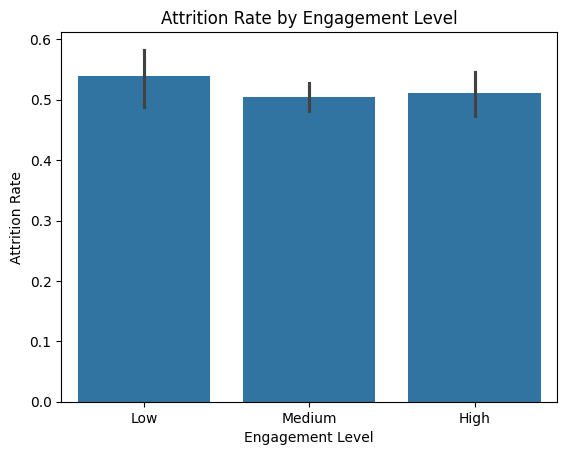

In [30]:
# ==============================
# Attrition vs Engagement
# ==============================

df["engagement_level"] = pd.cut(
    df["engagement_proxy"],
    bins=[0, 2, 3.5, 5],
    labels=["Low", "Medium", "High"]
)

sns.barplot(
    data=df,
    x="engagement_level",
    y="attrition_flag",
    estimator=np.mean
)
plt.title("Attrition Rate by Engagement Level")
plt.ylabel("Attrition Rate")
plt.xlabel("Engagement Level")
plt.show()

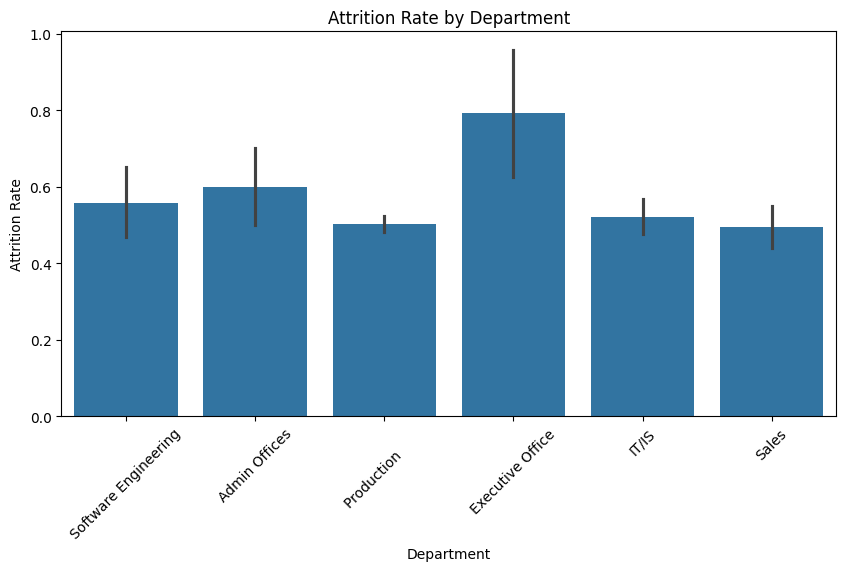

In [31]:
# ==============================
# Attrition by Department
# ==============================

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df,
    x="DepartmentType",
    y="attrition_flag",
    estimator=np.mean
)
plt.title("Attrition Rate by Department")
plt.xlabel("Department")
plt.ylabel("Attrition Rate")
plt.xticks(rotation=45)
plt.show()

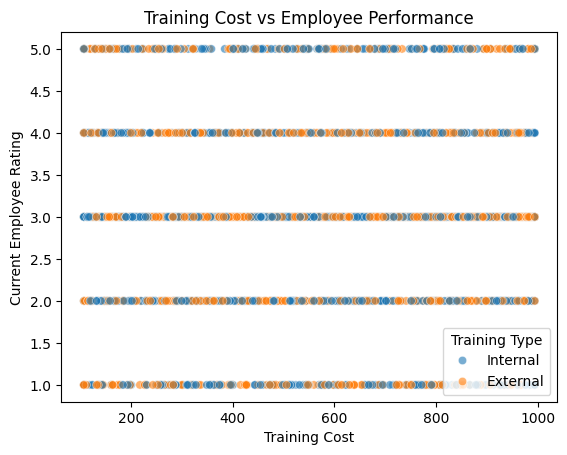

In [32]:
# ==============================
# Training Cost vs Performance
# ==============================

sns.scatterplot(
    data=df,
    x="Training Cost",
    y="Current Employee Rating",
    hue="Training Type",
    alpha=0.6
)
plt.title("Training Cost vs Employee Performance")
plt.show()

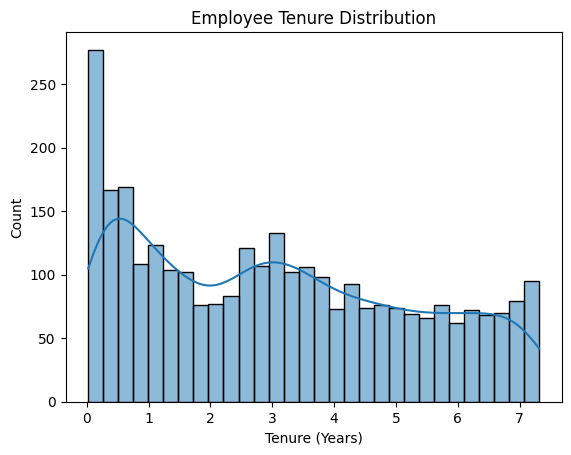

In [33]:
# ==============================
# Tenure Distribution
# ==============================

sns.histplot(df["tenure_years"], bins=30, kde=True)
plt.title("Employee Tenure Distribution")
plt.xlabel("Tenure (Years)")
plt.show()

In [34]:
# ==============================
# Modeling Setup
# ==============================

# Target variable
y = df["attrition_flag"]

# Feature set (NO leakage)
features = [
    "age",
    "age_missing_flag",
    "engagement_proxy",
    "Training Cost",
    "Training Duration(Days)",
    "Current Employee Rating"
]

X = df[features]

print("Features used for modeling:")
print(X.columns.tolist())

print("\nTarget distribution:")
print(y.value_counts())

Features used for modeling:
['age', 'age_missing_flag', 'engagement_proxy', 'Training Cost', 'Training Duration(Days)', 'Current Employee Rating']

Target distribution:
attrition_flag
1    1533
0    1467
Name: count, dtype: int64


In [35]:
# ==============================
# Train-Test Split
# ==============================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

print("\nTarget distribution (train):")
print(y_train.value_counts(normalize=True))

print("\nTarget distribution (test):")
print(y_test.value_counts(normalize=True))

Training set shape: (2250, 6)
Test set shape: (750, 6)

Target distribution (train):
attrition_flag
1    0.511111
0    0.488889
Name: proportion, dtype: float64

Target distribution (test):
attrition_flag
1    0.510667
0    0.489333
Name: proportion, dtype: float64


In [36]:
# ==============================
# Feature Scaling
# ==============================

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling completed")

✅ Feature scaling completed


In [37]:
# ==============================
# Logistic Regression
# ==============================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Train model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluation
roc_auc = roc_auc_score(y_test, y_prob)
print("Logistic Regression ROC-AUC:", round(roc_auc, 3))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
confusion_matrix(y_test, y_pred)

Logistic Regression ROC-AUC: 0.489

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.19      0.27       367
           1       0.51      0.82      0.63       383

    accuracy                           0.51       750
   macro avg       0.50      0.50      0.45       750
weighted avg       0.50      0.51      0.45       750


Confusion Matrix:


array([[ 68, 299],
       [ 69, 314]])

In [38]:
# ==============================
# Random Forest Model
# ==============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=10,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
rf_roc_auc = roc_auc_score(y_test, rf_prob)
print("Random Forest ROC-AUC:", round(rf_roc_auc, 3))

print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

print("\nConfusion Matrix:")
confusion_matrix(y_test, rf_pred)

Random Forest ROC-AUC: 0.482

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.45      0.47       367
           1       0.51      0.55      0.53       383

    accuracy                           0.50       750
   macro avg       0.50      0.50      0.50       750
weighted avg       0.50      0.50      0.50       750


Confusion Matrix:


array([[164, 203],
       [174, 209]])

In [39]:
# ==============================
# Model Comparison
# ==============================

model_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "ROC_AUC": [roc_auc, rf_roc_auc]
})

model_comparison

,Model,ROC_AUC
0,Logistic Regression,0.488898
1,Random Forest,0.481641


In [40]:
# ==============================
# Feature Importance
# ==============================

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values(ascending=False)

feature_importance

,0
Training Cost,0.354260
age,0.229661
engagement_proxy,0.210190
Training Duration(Days),0.097282
Current Employee Rating,0.086937
age_missing_flag,0.021669


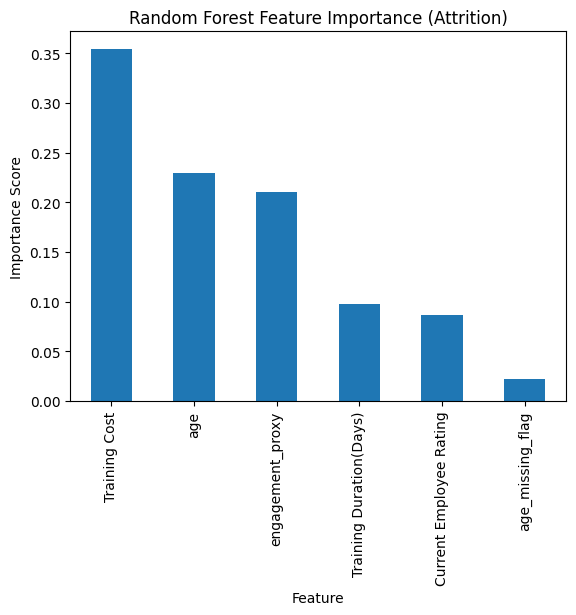

In [41]:
# ==============================
# Feature Importance Plot
# ==============================

feature_importance.plot(kind="bar")
plt.title("Random Forest Feature Importance (Attrition)")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.show()

In [42]:
df.to_csv("hr_cleaned.csv", index=False)

In [43]:
import joblib

joblib.dump(log_reg, "logistic_regression.pkl")
joblib.dump(rf_model, "random_forest.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']